1. hypster stored_values

1. improvements - query enhancement

1. evals

1. from vibe checks to supervised learning / HPO
1. 1. A system that notes the relevant parts for a question and feedback for each part and stores it in a db + improves the prompts and process
1. 1. Suggests different HPs or the next HP for testing :)

1. caching
1. tracing, logging - with MLFLOW (or langfuse)

1. hypster registry?
1. hypernodes with haystack backend?

1. Looping, conditional, routers, web ...

1. using pydantic/json for multiple llm summaries with different keys in the metadata

1. parallel runs for indexing multiple documents

# Config

In [1]:
from hypster import HP, config

In [2]:
@config
def indexing_config(hp: HP):
    from haystack.components.converters import PyPDFToDocument

    converter = PyPDFToDocument()

    from haystack import Pipeline

    pipeline = Pipeline()
    pipeline.add_component("loader", converter)

    enrich_doc_w_llm = hp.select([True, False], default=True)
    if enrich_doc_w_llm:
        from haystack.components.builders import PromptBuilder

        from src.haystack_utils import AddLLMMetadata

        template = hp.text_input("""
        Please provide a one sentence summary of 15 words max what this document is about.
        Then add a list of 3-5 keywords, including acronyms, that will help to find this document using keywords.
        Context:
        {{ documents[0].content[:1000] }}
        Output format:

        Summary:
        Keywords:
        """)
        from hypster import load

        llm = load("configs/llm.py")
        llm_inputs = hp.propagate(llm)
        pipeline.add_component("prompt_builder", PromptBuilder(template=template))
        pipeline.add_component("llm", llm_inputs["llm"])
        pipeline.add_component("document_enricher", AddLLMMetadata())
        pipeline.connect("loader", "prompt_builder")
        pipeline.connect("prompt_builder", "llm")
        pipeline.connect("llm", "document_enricher")
        pipeline.connect("loader", "document_enricher")

        doc_source = "document_enricher"
    else:
        doc_source = "loader"

    from haystack.components.preprocessors import DocumentSplitter

    split_by = hp.select(["sentence", "word", "passage", "page"], default="sentence")
    splitter = DocumentSplitter(split_by=split_by, split_length=hp.int_input(10), split_overlap=hp.int_input(2))

    pipeline.add_component("splitter", splitter)
    pipeline.connect(doc_source, "splitter")


indexing_config.save("configs/indexing.py")

In [3]:
@config
def fast_embed(hp: HP):
    from typing import Any, Dict, List

    from fastembed import TextEmbedding

    def get_model_dim(chosen_model: str, model_list: List[Dict[str, Any]]) -> int:
        for model in model_list:
            if model["model"] == chosen_model:
                return model["dim"]
        raise ValueError(f"Model {chosen_model} not found in the list of supported models.")

    from haystack_integrations.components.embedders.fastembed import (
        FastembedDocumentEmbedder,
        FastembedTextEmbedder,
    )

    meta_fileds_to_embed = ["parent_doc_summary"]

    model = hp.select(
        {"bge-small": "BAAI/bge-small-en-v1.5", "mini-lm": "sentence-transformers/all-MiniLM-L6-v2"},
        default="mini-lm",
    )
    import os

    cpu_count = os.cpu_count() or 1
    doc_embedder = FastembedDocumentEmbedder(
        model=model,
        parallel=hp.int_input(cpu_count),
        meta_fields_to_embed=meta_fileds_to_embed,
    )
    text_embedder = FastembedTextEmbedder(model=model)
    embedding_dim = get_model_dim(model, TextEmbedding.list_supported_models())


fast_embed.save("configs/fast_embed.py")

In [4]:
@config
def jina_embed(hp: HP):
    from haystack_integrations.components.embedders.jina import JinaDocumentEmbedder, JinaTextEmbedder

    meta_fileds_to_embed = ["parent_doc_summary"]

    model = hp.select({"v3": "jina-embeddings-v3", "v2": "jina-embeddings-v2"}, default="v3")
    late_chunking = hp.select([True, False], default=True, name="late_chunking") if model == "v3" else False
    doc_embedder = JinaDocumentEmbedder(
        model=model,
        batch_size=hp.int_input(16),
        dimensions=hp.int_input(256),
        task="retrieval.passage",
        late_chunking=late_chunking,
        meta_fields_to_embed=meta_fileds_to_embed,
    )
    text_embedder = JinaTextEmbedder(model=model, dimensions=doc_embedder.dimensions, task="retrieval.query")
    embedding_dim = doc_embedder.dimensions


jina_embed.save("configs/jina_embed.py")

In [5]:
@config
def in_memory_retrieval(hp: HP):
    from haystack.components.retrievers.in_memory import InMemoryBM25Retriever, InMemoryEmbeddingRetriever
    from haystack.document_stores.in_memory import InMemoryDocumentStore

    embedding_similarity_function = hp.select(["cosine", "dot_product"], default="cosine")
    bm25_algorithm = hp.select(["BM25Okapi", "BM25L", "BM25Plus"], default="BM25L")
    document_store = InMemoryDocumentStore(
        embedding_similarity_function=embedding_similarity_function, bm25_algorithm=bm25_algorithm
    )

    from haystack.components.joiners.document_joiner import DocumentJoiner

    join_mode = hp.select(
        ["distribution_based_rank_fusion", "concatenate", "merge", "reciprocal_rank_fusion"],
        default="distribution_based_rank_fusion",
    )
    joiner = DocumentJoiner(join_mode=join_mode, top_k=hp.int_input(10))

    from haystack import Pipeline

    from src.haystack_utils import PassThroughDocuments, PassThroughText

    pipeline = Pipeline()
    pipeline.add_component("query", PassThroughText())
    pipeline.add_component("bm25_retriever", InMemoryBM25Retriever(document_store=document_store))
    pipeline.add_component("embedding_retriever", InMemoryEmbeddingRetriever(document_store=document_store))
    pipeline.add_component("document_joiner", joiner)
    pipeline.add_component("retrieved_documents", PassThroughDocuments())
    pipeline.connect("query", "bm25_retriever")
    pipeline.connect("bm25_retriever", "document_joiner")
    pipeline.connect("embedding_retriever", "document_joiner")
    pipeline.connect("document_joiner", "retrieved_documents")


in_memory_retrieval.save("configs/in_memory_retrieval.py")

In [6]:
@config
def qdrant_retrieval(hp: HP):
    from haystack_integrations.components.retrievers.qdrant import QdrantEmbeddingRetriever
    from haystack_integrations.document_stores.qdrant import QdrantDocumentStore

    location = hp.text_input(":memory:")
    embedding_similarity_function = hp.select(["cosine", "dot_product", "l2"], default="cosine")

    # if "embedding_dim" in hp.stored_values:
    #     embedding_dim = hp.stored_value["embedding_dim"]
    # else:
    #     embedding_dim = hp.int_input(256)

    document_store = QdrantDocumentStore(
        location=location,
        recreate_index=True,
        similarity=embedding_similarity_function,
        # embedding_dim=embedding_dim,
        on_disk=True,
    )

    embedding_retriever = QdrantEmbeddingRetriever(document_store=document_store, top_k=hp.int_input(20))

    from haystack import Pipeline

    from src.haystack_utils import PassThroughDocuments, PassThroughText

    pipeline = Pipeline()
    pipeline.add_component("query", PassThroughText())
    pipeline.add_component("embedding_retriever", embedding_retriever)
    pipeline.add_component("retrieved_documents", PassThroughDocuments())
    pipeline.connect("embedding_retriever", "retrieved_documents")


qdrant_retrieval.save("configs/qdrant_retrieval.py")

In [7]:
@config
def llm(hp: HP):
    anthropic_models = {"haiku": "claude-3-haiku-20240307", "sonnet": "claude-3-5-sonnet-20240620"}
    openai_models = {"gpt-4o-mini": "gpt-4o-mini", "gpt-4o": "gpt-4o", "gpt-4o-latest": "gpt-4o-2024-08-06"}
    model = hp.select({**anthropic_models, **openai_models}, default="gpt-4o-mini")
    from haystack.components.generators import OpenAIGenerator
    from haystack_integrations.components.generators.anthropic import AnthropicGenerator

    llm = AnthropicGenerator(model=model) if model in anthropic_models.values() else OpenAIGenerator(model=model)


llm.save("configs/llm.py")

In [8]:
@config
def reranker(hp: HP):
    jina_models = {
        "reranker-v2": "jina-reranker-v2-base-multilingual",
        "colbert-v2": "jina-colbert-v2",
        "reranker-v1": "jina-reranker-v1-base-en",
    }

    transformers_models = {
        "tiny-bert-v2": "cross-encoder/ms-marco-TinyBERT-L-2-v2",
        "minilm-v2": "cross-encoder/ms-marco-MiniLM-L-2-v2",
    }

    model = hp.select({**jina_models, **transformers_models}, default="reranker-v2")
    if model in jina_models.values():
        from haystack_integrations.components.rankers.jina import JinaRanker

        reranker = JinaRanker(model=model, top_k=hp.int_input(3))
    else:
        from haystack.components.rankers import TransformersSimilarityRanker

        reranker = TransformersSimilarityRanker(model=model, top_k=hp.int_input(3))


reranker.save("configs/reranker.py")

In [9]:
@config
def hp_config(hp: HP):
    from hypster import load

    file_path = hp.text_input("data/raw/modular_rag.pdf")
    query = "What is the use of BERT in this document?"

    indexing_config = load("configs/indexing.py")
    indexing = hp.propagate(indexing_config)
    indexing_pipeline = indexing["pipeline"]

    fast_embed = load("configs/fast_embed.py")
    jina_embed = load("configs/jina_embed.py")
    embedder = hp.select({"fastembed": hp.propagate(fast_embed), "jina": hp.propagate(jina_embed)}, default="fastembed")
    indexing_pipeline.add_component("doc_embedder", embedder["doc_embedder"])

    qdrant = load("configs/qdrant_retrieval.py")
    in_memory = load("configs/in_memory_retrieval.py")
    document_store = hp.select(
        {"in_memory": hp.propagate(in_memory), "qdrant": hp.propagate(qdrant)}, default="in_memory"
    )

    from haystack.components.writers import DocumentWriter
    from haystack.document_stores.types import DuplicatePolicy

    document_writer = DocumentWriter(document_store["document_store"], policy=DuplicatePolicy.OVERWRITE)
    indexing_pipeline.add_component("document_writer", document_writer)

    indexing_pipeline.connect("splitter", "doc_embedder")
    indexing_pipeline.connect("doc_embedder", "document_writer")

    retrieval_pipeline = document_store["pipeline"]
    retrieval_pipeline.add_component("text_embedder", embedder["text_embedder"])
    retrieval_pipeline.connect("query", "text_embedder")
    retrieval_pipeline.connect("text_embedder", "embedding_retriever")

    from src.haystack_utils import PassThroughDocuments

    retrieval_pipeline.add_component("docs_for_generation", PassThroughDocuments())
    use_reranker = hp.select([True, False], default=True)
    if use_reranker:
        reranker_config = load("configs/reranker.py")
        reranker = hp.propagate(reranker_config)
        retrieval_pipeline.add_component("reranker", reranker["reranker"])
        retrieval_pipeline.connect("retrieved_documents", "reranker")
        retrieval_pipeline.connect("reranker", "docs_for_generation")
        retrieval_pipeline.connect("query", "reranker")
    else:
        retrieval_pipeline.connect("retrieved_documents", "docs_for_generation")

    llm = load("configs/llm.py")
    large_llm_model = hp.propagate(llm)

    from textwrap import dedent

    from haystack import Pipeline
    from haystack.components.builders import PromptBuilder
    template = dedent("""
    Given the following information, answer the question in one short sentence, 
    using the information provided in the documents. 
    Add an exact quote from the documents that you based your answer on.
    Note: In some cases, only one or some of the documents will be relevant to the question.
    ========================================
    Context:
    {% for document in documents %}
        <Document {{ document.id }}>
        <LLM Extracted Information>
        {{ document.meta.llm_extracted_info }}
        <\LLM Extracted Information>
        <Document Content>
        {{ document.content }}
        <\Document Content>
        <\Document {{ document.id }}>
        \n
    {% endfor %}
    ========================================
    Question: {{question}}
    Chain of Thought:
    Answer:
    Quotes:
    """)

    response_pipeline = Pipeline()
    response_pipeline.add_component("prompt_builder", PromptBuilder(template=template))
    response_pipeline.add_component("llm", large_llm_model["llm"])
    response_pipeline.connect("prompt_builder", "llm")

In [10]:
inputs = hp_config(
    selections={
        "indexing."
        "large_llm_model.model": "gpt-4o",
        "document_store": "in_memory",
        "document_store.bm25_algorithm": "BM25Plus",
        "indexing_inputs.llm_inputs.model": "gpt-4o-mini",
        "reranker.model": "tiny-bert-v2",
    }
)

/opt/miniconda3/envs/haystack-demo/lib/python3.10/site-packages/haystack/core/errors.py:34: DeprecationWarning: PipelineMaxLoops is deprecated and will be remove in version '2.7.0'; use PipelineMaxComponentRuns instead.
  warnings.warn(


In [11]:
globals().update(inputs)

In [12]:
indexing_pipeline.warm_up()
file_paths = ["data/raw/modular_rag.pdf", "data/raw/enhancing_rag.pdf"]
for file_path in file_paths:
    indexing_pipeline.run({"loader": {"sources": [file_path]}})

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating embeddings: 100%|██████████| 56/56 [00:00<00:00, 90.27it/s]


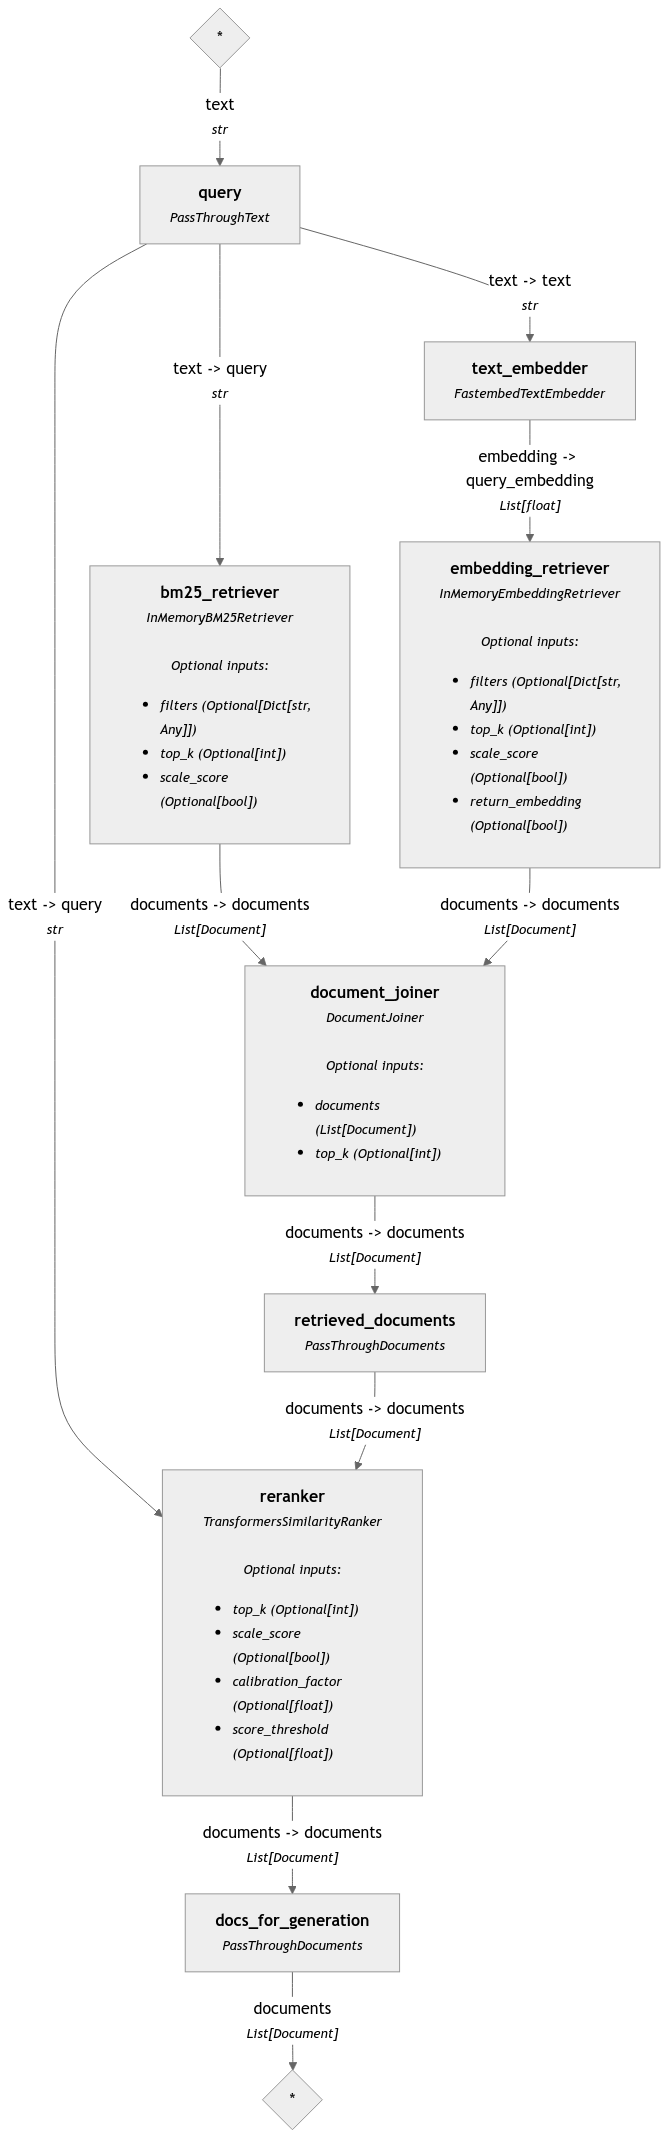

In [13]:
retrieval_pipeline.show()

In [14]:
retrieval_pipeline.warm_up()

In [33]:
query = "What is the use of BERT or ColBERT in RAG?"
retrieval = retrieval_pipeline.run({"query": {"text": query}})

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00, 160.96it/s]


In [34]:
retrieval["docs_for_generation"]["documents"][0].id

'5b529e728336c265a61ef1913827a49e6b4e045d1e4f88964289a74863b1426a'

In [35]:
for doc in retrieval["docs_for_generation"]["documents"]:
    print(doc.content)
    print(doc.meta)
    print()

 Typical models
include BERT structure PLMs, like ColBERT, and multi-task
fine-tuned models like BGE [40] and GTE [41].
Hybrid Retriever is to use both sparse and dense retrievers
simultaneously. Two embedding techniques complement each
other to enhance retrieval effectiveness. Sparse retriever can
provide initial screening results. Additionally, sparse models
enhance the zero-shot retrieval capabilities of dense models,
particularly in handling queries with rare entities, thereby
increasing system robustness.
2) Retriever Fine-tuning: In cases where the context may
diverge from pre-trained corpus, particularly in highly special-
ized fields like healthcare, law, and other domains abundant in
proprietary terminology. While this adjustment demands addi-
tional effort, it can substantially enhance retrieval efficiency
and domain alignment.
Supervised Fine-Tuning (SFT). Fine-tuning a retrieval
model based on labeled domain data is typically done using
contrastive learning. This involves r

In [36]:
retrieval["docs_for_generation"]["documents"]

[Document(id=5b529e728336c265a61ef1913827a49e6b4e045d1e4f88964289a74863b1426a, content: ' Typical models
 include BERT structure PLMs, like ColBERT, and multi-task
 fine-tuned models like BGE...', meta: {'file_path': 'data/raw/modular_rag.pdf', 'llm_extracted_info': 'Summary:  \nThe document discusses the transformation of Retrieval-Augmented Generation systems into modular, flexible frameworks.  \n\nKeywords:  \nRAG, LLM, modular frameworks, knowledge-intensive tasks, retrieval-augmented generation', 'source_id': '5f28e9ba2f68a429a7e1eb20312eca74fa1e77a4aabed058a078104a878815f9', 'page_number': 6, 'split_id': 32, 'split_idx_start': 26524, '_split_overlap': [{'doc_id': '1942c1d810a3008adc53c622bb061da7dc03ad89bda88322078fb882deabfcc8', 'range': (736, 931)}, {'doc_id': 'e2e54018d3278a81973d9765075ef42f4673e0c53e789fc3435335e813b9c5f1', 'range': (0, 224)}]}, score: 0.6772783398628235, embedding: vector of size 384),
 Document(id=eedffeb121bfc8441132add104fcdeafda1c6fa5a854671e8f997d7a09b

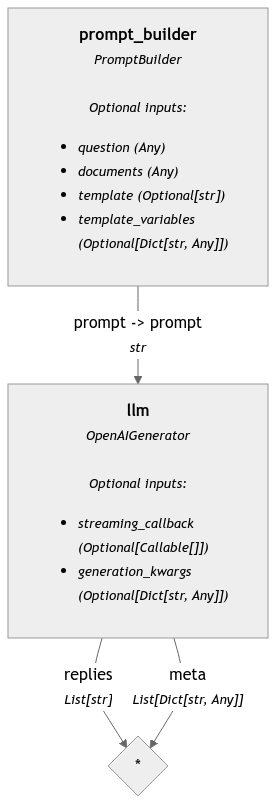

In [37]:
response_pipeline.show()

In [38]:
response_pipeline = inputs["response_pipeline"]
response_pipeline.warm_up()
response = response_pipeline.run(
    {"prompt_builder": {"question": query, "documents": retrieval["docs_for_generation"]["documents"]}},
    include_outputs_from={"prompt_builder"},
)

In [39]:
print(response["prompt_builder"]["prompt"])


Given the following information, answer the question in one short sentence, 
using the information provided in the documents. 
Add an exact quote from the documents that you based your answer on.
Note: In some cases, only one or some of the documents will be relevant to the question.
Context:

    <Document 5b529e728336c265a61ef1913827a49e6b4e045d1e4f88964289a74863b1426a>
    <LLM Extracted Information>
    Summary:  
The document discusses the transformation of Retrieval-Augmented Generation systems into modular, flexible frameworks.  

Keywords:  
RAG, LLM, modular frameworks, knowledge-intensive tasks, retrieval-augmented generation
    <\LLM Extracted Information>
    <Document Content>
     Typical models
include BERT structure PLMs, like ColBERT, and multi-task
fine-tuned models like BGE [40] and GTE [41].
Hybrid Retriever is to use both sparse and dense retrievers
simultaneously. Two embedding techniques complement each
other to enhance retrieval effectiveness. Sparse retriever

In [40]:
print(response["llm"]["replies"][0])

BERT and ColBERT are used for improved accuracy, relevance, and contextual richness in document retrieval within RAG systems. "Pierre et al. Query optimization in RAG BERT, Orca2, prompt augmenter Improved accuracy, relevance, and contextual richness in document retrieval."


In [41]:
response["llm"]["meta"]

[{'model': 'gpt-4o-2024-08-06',
  'index': 0,
  'finish_reason': 'stop',
  'usage': {'completion_tokens': 56,
   'prompt_tokens': 1293,
   'total_tokens': 1349,
   'completion_tokens_details': CompletionTokensDetails(audio_tokens=None, reasoning_tokens=0),
   'prompt_tokens_details': PromptTokensDetails(audio_tokens=None, cached_tokens=0)}}]